In [22]:
from astropy.io import fits
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import subprocess
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage
import keras
from keras.models import load_model
from __future__ import print_function
%matplotlib inline

In [34]:
gpu_code_path = "../code/gpu/"
real_image_name = "chip_1"
real_image_path = "/home/kbmod-usr/cuda-workspace/fraizer/chip_1"#"../../HITS/trimmed_chip_03/Blind15A_02/night_1" #gpu_code_path+"images/"+real_image_name
psi_image_path = gpu_code_path+"output-images/psi"
phi_image_path = gpu_code_path+"output-images/phi"

In [35]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
#image_times*=24.

Load Psi Images

In [36]:
hdulist = fits.open(os.path.join(psi_image_path, os.listdir(psi_image_path)[0]))
num_images = len(os.listdir(psi_image_path))
image_shape = np.shape(hdulist[0].data)
im_psi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(psi_image_path)))):

    #print (str('Loaded ' + filename))

    image_file = os.path.join(psi_image_path, filename)
    hdulist = fits.open(image_file)
    im_psi_array[idx] = hdulist[0].data#*mask


Load Phi Images (for potentially making psi/phi stamps)

In [37]:
hdulist = fits.open(os.path.join(phi_image_path, os.listdir(phi_image_path)[0]))
num_images = len(os.listdir(phi_image_path))
image_shape = np.shape(hdulist[0].data)
im_phi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(phi_image_path)))):

   # print (str('Loaded ' + filename))

    image_file = os.path.join(phi_image_path, filename)
    hdulist = fits.open(image_file)
    im_phi_array[idx] = hdulist[0].data#*mask


In [38]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

   # print( str('Loaded ' + filename))

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


In [39]:
ai = analyzeImage()

In [59]:
%timeit model = load_model('../../HITS/neural_net/new_kbmod_model.h5')

1 loop, best of 3: 3.75 s per loop


In [43]:
raw_results = np.genfromtxt('../data/results/maskReject.txt', names=True)

In [44]:
results = raw_results[0:180000] #np.where(raw_results['t0_y'] )#
print(len(results))
results

180000


array([(1347.0, 1286.0, 0.0, 0.0, 157.127, 231.757, 66.027, 6755.005),
       (1347.0, 1287.0, 0.0, 0.0, 157.127, 231.757, 65.337, 6858.982),
       (1347.0, 1285.0, 0.0, 0.0, 157.127, 231.757, 63.434, 6341.433), ...,
       (643.0, 2585.0, 0.0, 0.0, 306.529, 129.598, 1.882, 160.129),
       (328.0, 2608.0, 0.0, 0.0, 312.623, 114.116, 1.882, 158.284),
       (494.0, 2642.0, 0.0, 0.0, 420.668, 10.519, 1.883, 157.861)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [45]:
results_to_cluster = results
arg = dict(eps=0.005, min_samples=1, n_jobs=-1)
clustered_results = ai.clusterResults(results_to_cluster, dbscan_args=arg)#, im_array, image_times)
clustered_results =  results_to_cluster[np.array(clustered_results[1], dtype=np.int)]
#best_targets = range(stamp_count)
#best_targets

In [46]:
print( len(clustered_results) )
clustered_results

2235


array([(1347.0, 1286.0, 0.0, 0.0, 157.127, 231.757, 66.027, 6755.005),
       (1344.0, 1956.0, 0.0, 0.0, 162.065, 239.04, 53.221, 4616.761),
       (1327.0, 1369.0, 0.0, 0.0, 315.2, 0.0, 36.155, 3107.4), ...,
       (1254.0, 2145.0, 0.0, 0.0, 378.755, 138.256, 1.883, 156.163),
       (1868.0, 1136.0, 0.0, 0.0, 308.823, 200.131, 1.883, 155.629),
       (494.0, 2642.0, 0.0, 0.0, 420.668, 10.519, 1.883, 157.861)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [52]:
filtered_results = ai.filter_results(im_psi_array, clustered_results, image_times, model, chunk_size=100)

 32/100 [========>.....................] - ETA: 0sFinished chunk 23 of 23


In [53]:
print( len(filtered_results) )
filtered_results

249


array([(1344.0, 1956.0, 0.0, 0.0, 162.065, 239.04, 53.221, 4616.761),
       (1135.0, 3088.0, 0.0, 0.0, 320.89, 117.134, 32.141, 2738.612),
       (1700.0, 3980.0, 0.0, 0.0, 293.296, 115.449, 16.046, 1364.739),
       (1380.0, 1990.0, 0.0, 0.0, 179.479, 214.912, 8.245, 705.123),
       (783.0, 2136.0, 0.0, 0.0, 167.99, 234.914, 7.211, 627.426),
       (1263.0, 1446.0, 0.0, 0.0, 290.36, 97.836, 7.059, 604.032),
       (942.0, 305.0, 0.0, 0.0, 200.038, 195.921, 7.021, 594.102),
       (801.0, 2080.0, 0.0, 0.0, 296.763, 22.299, 6.669, 568.474),
       (364.0, 1592.0, 0.0, 0.0, 239.209, 191.469, 6.574, 570.436),
       (1956.0, 3606.0, 0.0, 0.0, 167.004, 246.324, 6.285, 551.074),
       (1871.0, 3146.0, 0.0, 0.0, 279.913, 6.999, 6.261, 528.702),
       (716.0, 1056.0, 0.0, 0.0, 284.161, 205.018, 6.082, 516.208),
       (839.0, 2080.0, 0.0, 0.0, 298.424, 126.172, 6.075, 524.37),
       (431.0, 1538.0, 0.0, 0.0, 195.967, 212.137, 5.981, 513.261),
       (44.0, 3671.0, 0.0, 0.0, 252.125, 121.

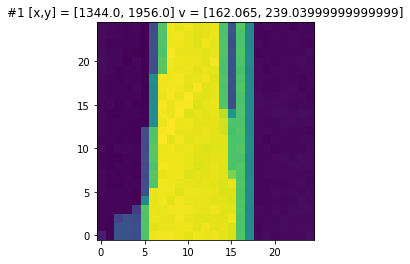

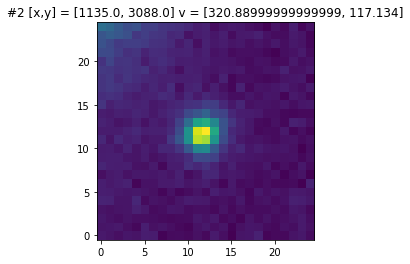

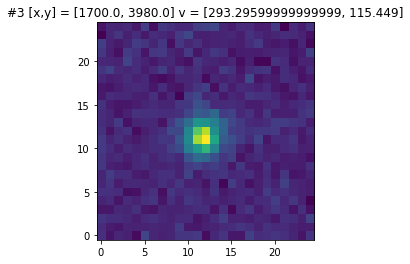

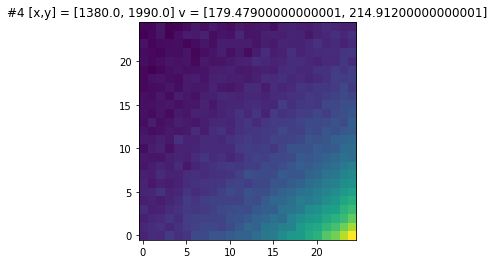

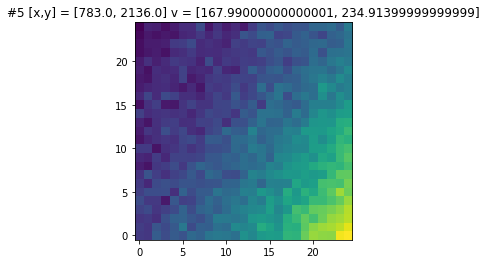

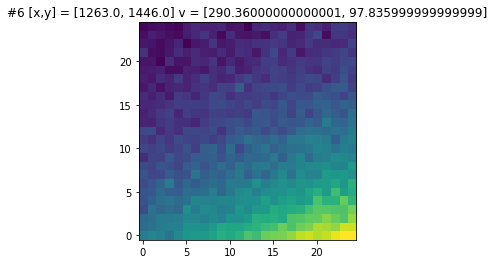

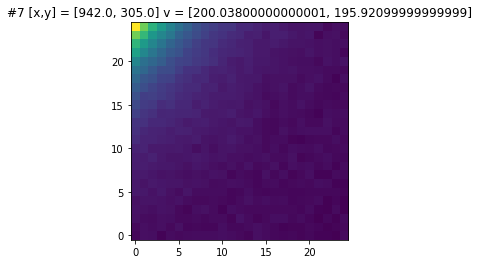

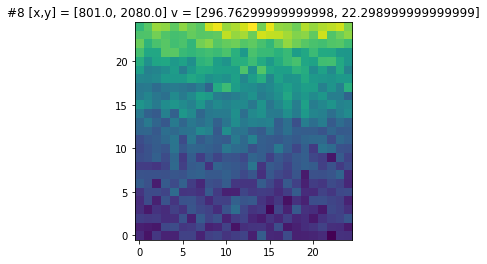

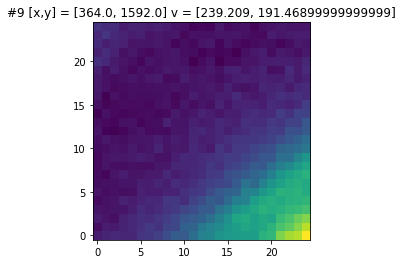

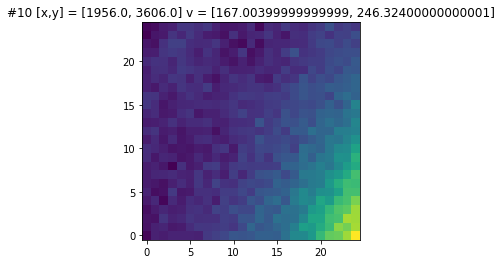

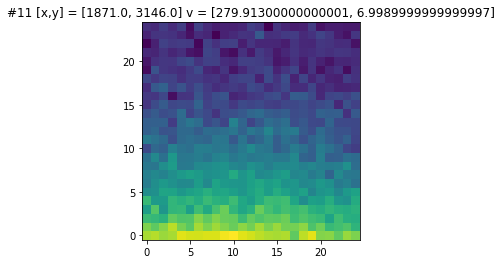

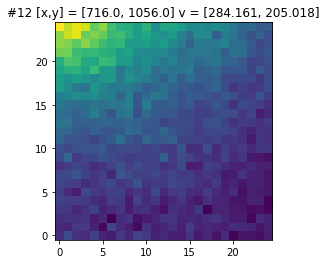

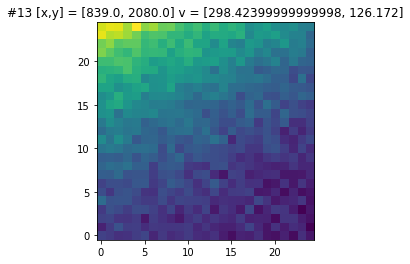

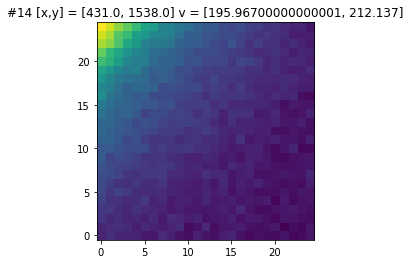

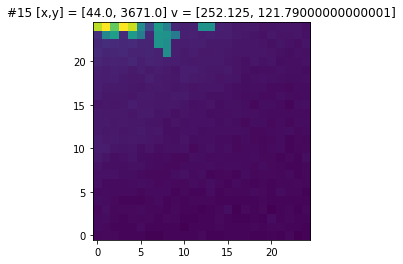

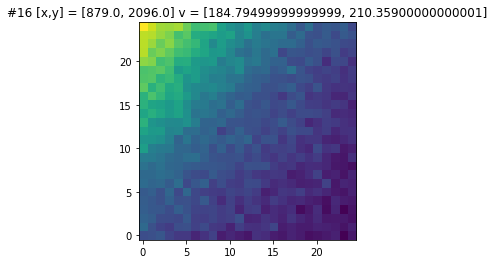

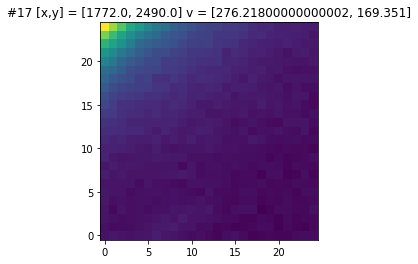

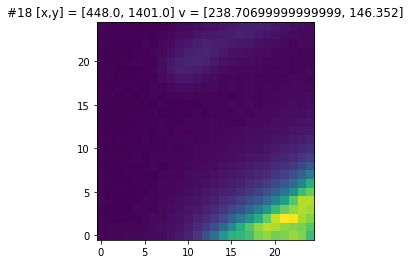

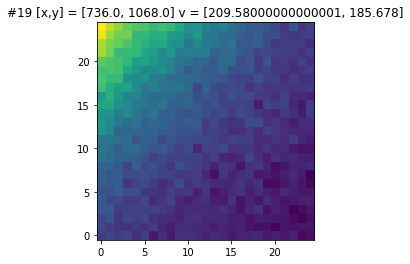

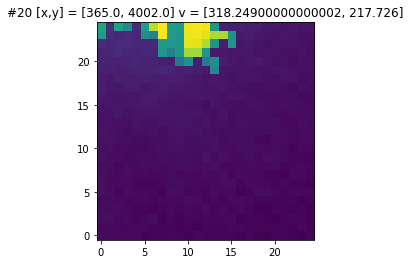

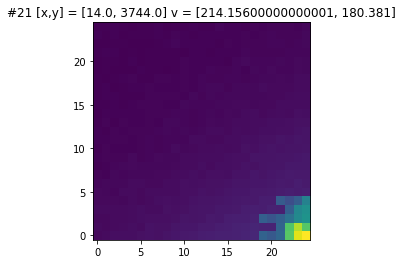

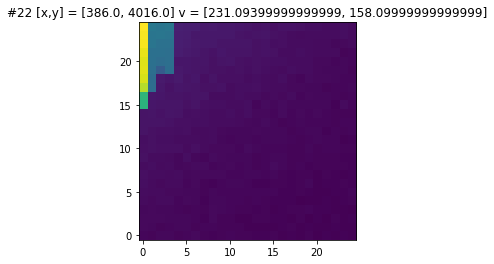

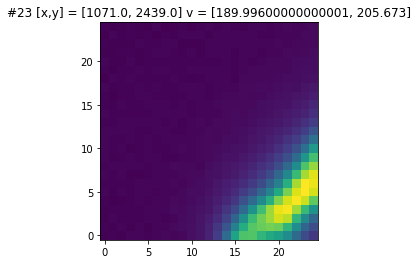

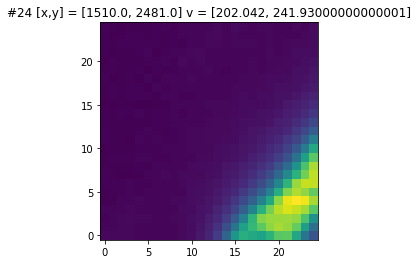

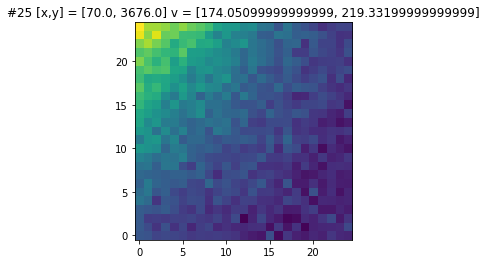

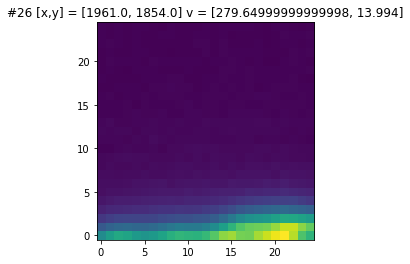

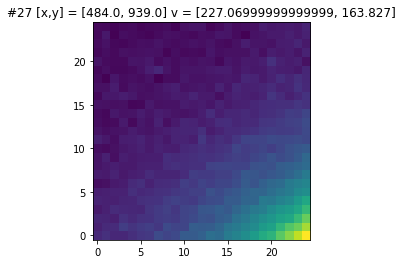

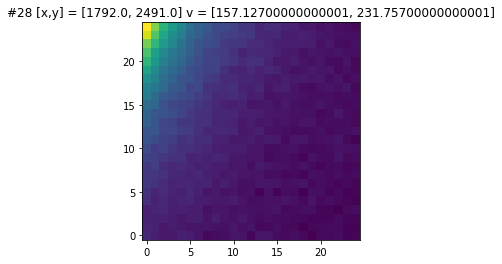

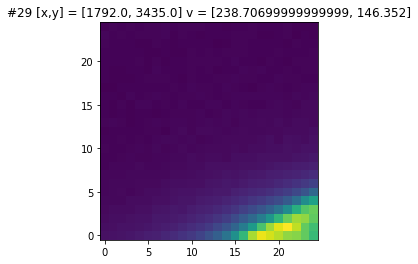

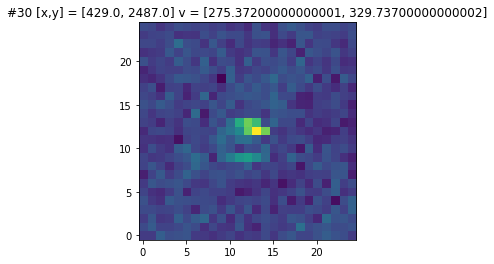

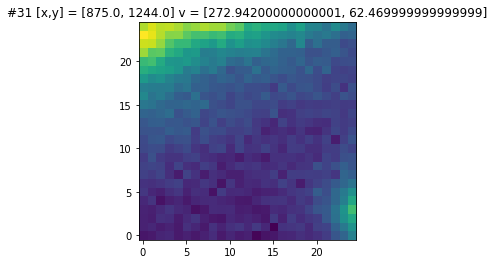

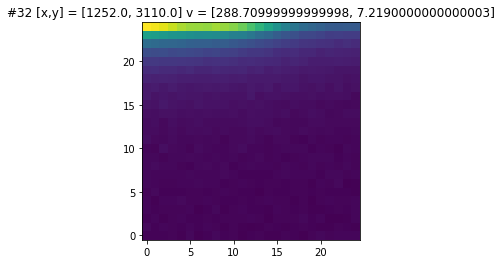

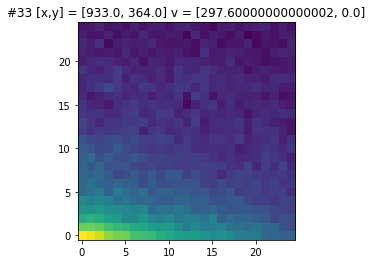

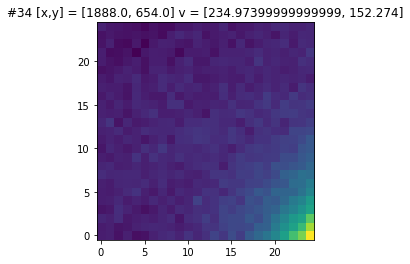

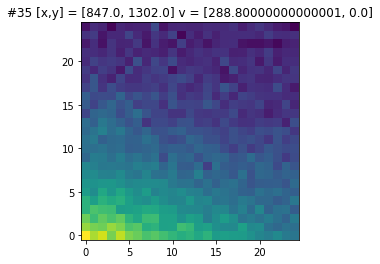

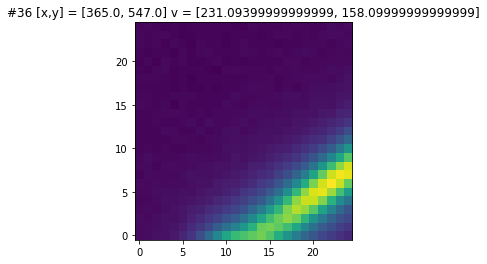

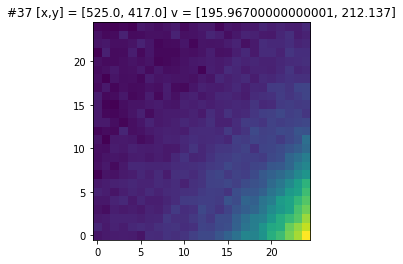

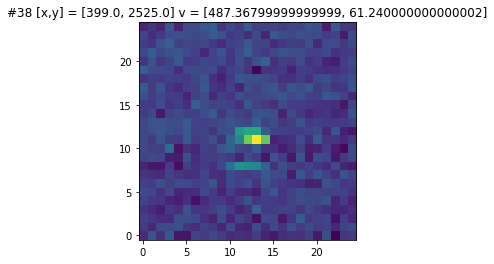

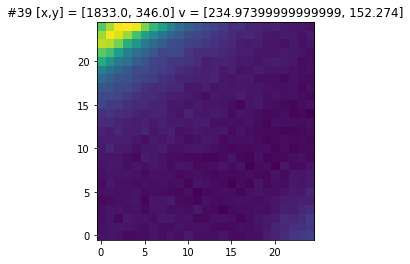

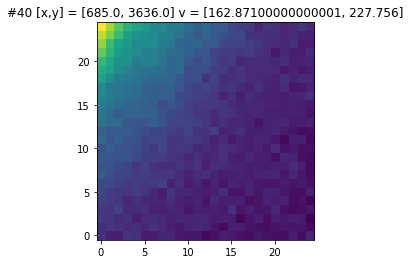

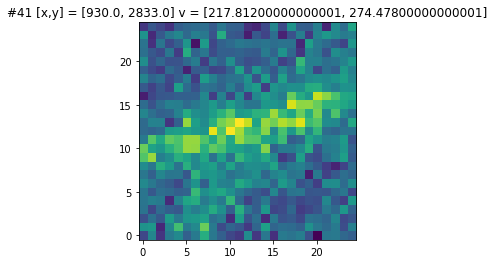

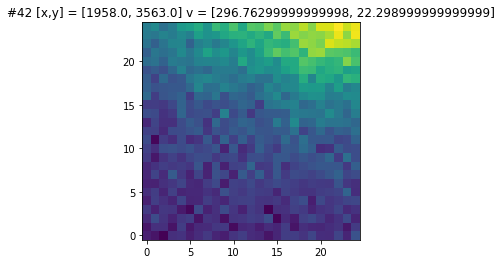

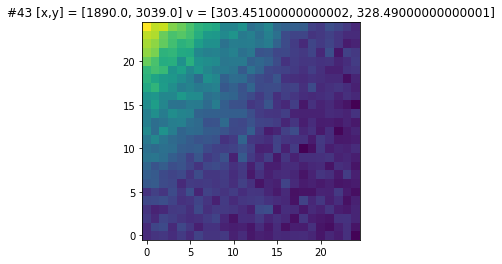

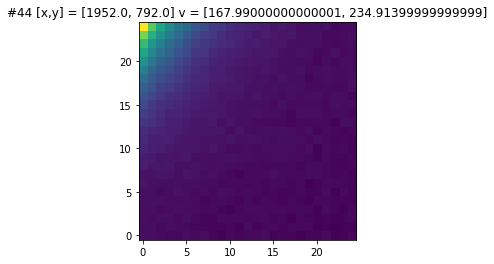

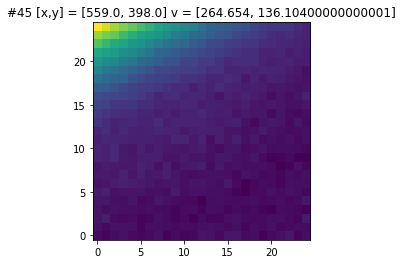

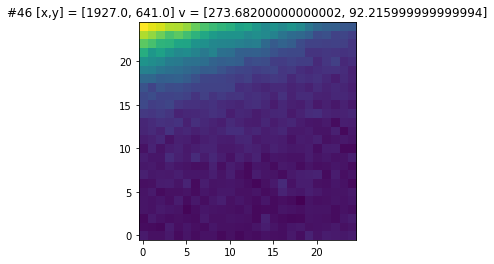

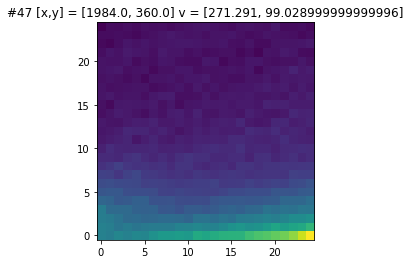

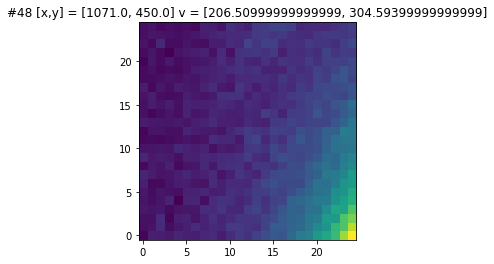

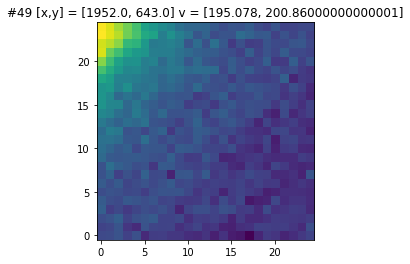

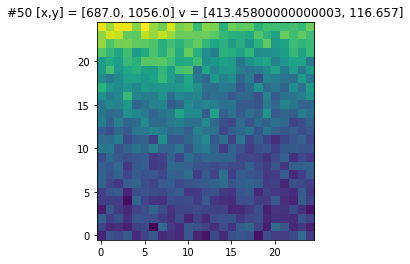

In [57]:
f_results = filtered_results
for imNum in range(min(len(f_results),50)):
    current = imNum#best_targets[imNum]
    try:
        plt.imshow(ai.createPostageStamp(im_array,
                                         list(f_results[['t0_x', 't0_y']][current]),
                                         np.array(list(f_results[['v_x', 'v_y']][current])),
                                         image_times, 
                                         [25., 25.])[0],
                    origin='lower',
               #cmap=plt.cm.Greys_r,
               interpolation='None')
        plt.title(str('#' + str(imNum+1) + ' [x,y] = ' + str(list(f_results[['t0_x', 't0_y']][current])))
                  + ' v = ' + str(list(f_results[['v_x', 'v_y']][current])))
 #   plt.savefig("stamps/stamp"+str(imNum+1)+".png")
        plt.show()
    except:
        print( "oh no" )


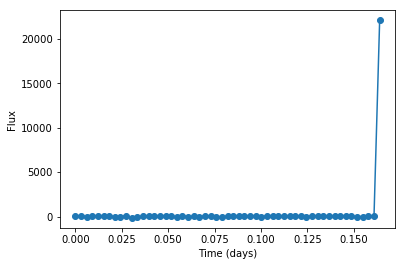

In [43]:
ai.plotLightCurves(im_array, f_results[9], image_times)
plt.show()

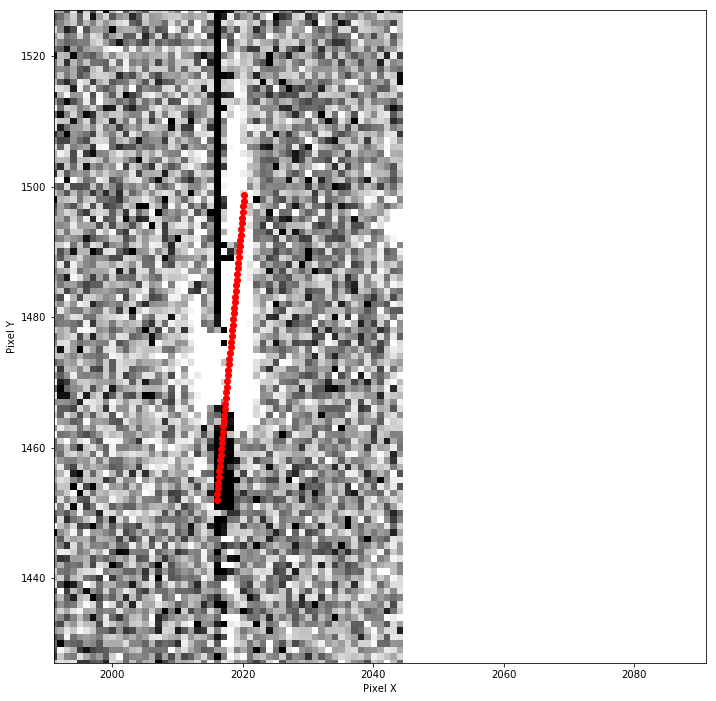

In [117]:
 fig = plt.figure(figsize=(12,12))
ax = ai.plotTrajectory(f_results[4], 
                        image_times, im_array[0], im_plot_args={'vmin':-111, 'vmax':111})
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [55]:
current = 1
ps = ai.createPostageStamp(im_array,
                                         list(f_results[['t0_x', 't0_y']][current]),
                                         np.array(list(f_results[['v_x', 'v_y']][current])),
                                         image_times, 
                                         [25., 25.])

IndexError: list index out of range

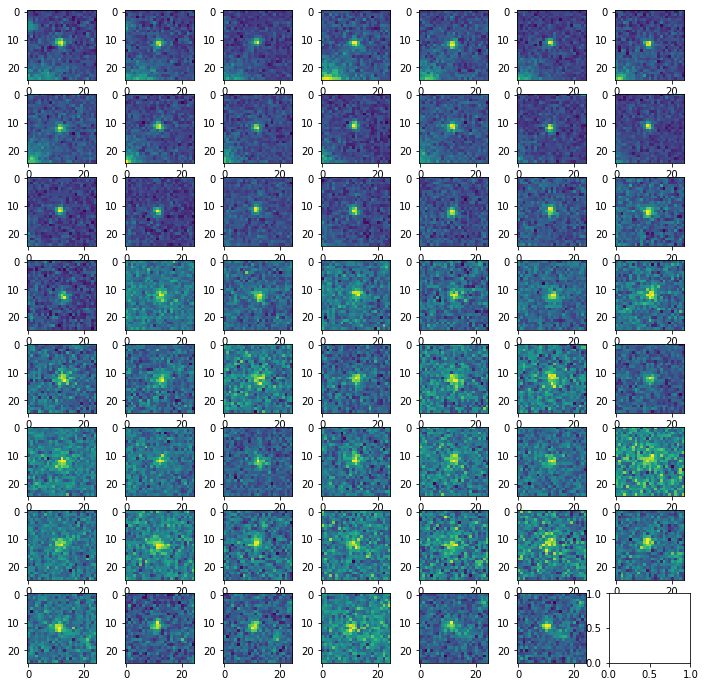

In [56]:
fig = plt.figure(figsize=(12,12))
for im_num in range(56):
    fig.add_subplot(8,7,im_num+1)
    plt.imshow(ps[1][im_num])

In [24]:
len(ps[1])

55